<a href="https://colab.research.google.com/github/RamanVer1ma/AgroFarm/blob/main/CHSModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

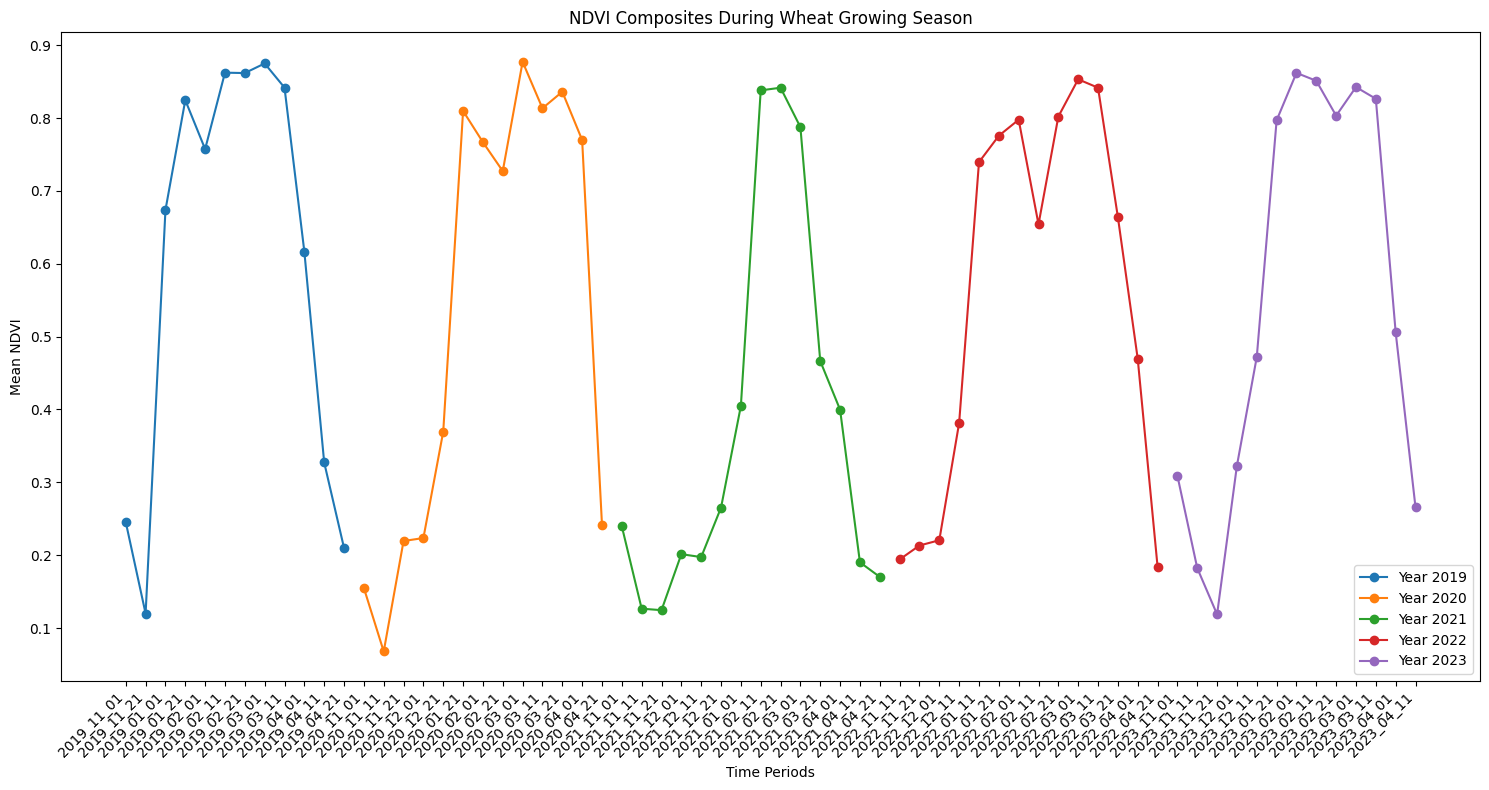

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ee.Authenticate()
ee.Initialize(project = 'agrofram')

def create_date_ranges(year):

    periods = []
    start_months = [11, 12, 1, 2, 3, 4]

    for month in start_months:
        for day_start in [1, 11, 21]:
            # Adjust year for January and February
            year_adjust = year if month not in [1, 2] else year + 1

            # Create start and end dates for 10-day periods
            start_date = ee.Date(f'{year if month >= 11 else year_adjust}-{month:02d}-{day_start:02d}')
            end_date = start_date.advance(10, 'day')

            periods.append({
                'start': start_date,
                'end': end_date,
                'label': f'{year}_{month:02d}_{day_start:02d}'
            })

    return periods

def load_and_process_ndvi(year, region):
    """
    Load Sentinel images and calculate NDVI composites for 5-10 day periods
    """
    # Get date ranges for the year
    periods = create_date_ranges(year)

    ndvi_composites = []

    for period in periods:
        # Load Sentinel-2 images for the period
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(period['start'], period['end']) \
            .filterBounds(region) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

        # If no images, append None
        if collection.size().getInfo() == 0:
            ndvi_composites.append({
                'date': period['label'],
                'ndvi': None
            })
            continue

        # Calculate NDVI composite
        ndvi_composite = collection \
            .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI')) \
            .mean()

        # Extract mean NDVI value
        mean_ndvi = ndvi_composite.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).get('NDVI').getInfo()

        ndvi_composites.append({
            'date': period['label'],
            'ndvi': mean_ndvi
        })

    return ndvi_composites

def plot_ndvi_composites(ndvi_data):
    """
    Plot NDVI composites across years
    """
    plt.figure(figsize=(15, 8))

    # Prepare data for plotting
    all_dates = []
    all_ndvis = []

    for year_data in ndvi_data:
        dates = [entry['date'] for entry in year_data if entry['ndvi'] is not None]
        ndvis = [entry['ndvi'] for entry in year_data if entry['ndvi'] is not None]

        plt.plot(dates, ndvis, marker='o', label=f'Year {dates[0][:4]}')

        all_dates.extend(dates)
        all_ndvis.extend(ndvis)

    plt.title('NDVI Composites During Wheat Growing Season')
    plt.xlabel('Time Periods')
    plt.ylabel('Mean NDVI')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return all_dates, all_ndvis

def main():
    # Define region of interest (example: Punjab, India)
    xmin, ymin = 75.84399, 30.81936
    xmax, ymax = 75.85511, 30.82714
    punjab = ee.Geometry.Rectangle([75.84399, 30.81936,75.85511, 30.82714])

    # Process NDVI for last 5 years
    ndvi_data = []
    for year in range(2019, 2024):
        year_ndvi = load_and_process_ndvi(year, punjab)
        ndvi_data.append(year_ndvi)

    # Plot NDVI composites
    dates, ndvis = plot_ndvi_composites(ndvi_data)

    # Print out details of missing data
    for year_data in ndvi_data:
        missing_periods = [entry['date'] for entry in year_data if entry['ndvi'] is None]
        if missing_periods:
            print(f"Missing periods: {missing_periods}")

if __name__ == '__main__':
    main()

In [ ]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

ee.Authenticate()
ee.Initialize(project = 'agrofram')

def generate_full_timestamp_range(start_year, end_year):
    """
    Generate complete timestamp range for wheat growing season
    """
    timestamps = []
    for year in range(start_year, end_year + 1):
        # Wheat growing season from Nov to May
        current_date = datetime(year, 11, 1)
        season_end = datetime(year + 1, 5, 31)

        while current_date <= season_end:
            timestamps.append(current_date)
            current_date += timedelta(days=10)

    return timestamps

def load_ndvi_for_period(start_date, end_date, region):
    """
    Load Sentinel images and calculate NDVI for specific period
    """
    # Convert datetime to ee.Date
    start = ee.Date(start_date.strftime('%Y-%m-%d'))
    end = ee.Date(end_date.strftime('%Y-%m-%d'))

    # Load Sentinel-2 images
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start, end) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))

    # If no images, return None
    if collection.size().getInfo() == 0:
        return None

    # Calculate NDVI composite
    ndvi_composite = collection \
        .map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI')) \
        .mean()

    # Extract mean NDVI value
    try:
        mean_ndvi = ndvi_composite.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region,
            scale=10,
            maxPixels=1e9
        ).get('NDVI').getInfo()
        return mean_ndvi
    except:
        return None

def create_ndvi_dataset(start_year, end_year):
    """
    Create comprehensive NDVI dataset
    """
  # Define region of interest (example: Punjab, India)
    xmin, ymin = 75.84399, 30.81936
    xmax, ymax = 75.85511, 30.82714
    punjab = ee.Geometry.Rectangle([75.84399, 30.81936,75.85511, 30.82714])


    # Generate full timestamp range
    timestamps = generate_full_timestamp_range(start_year, end_year)

    # Prepare data collection
    data = []
    for timestamp in timestamps:
        # 10-day period
        period_end = timestamp + timedelta(days=10)

        # Calculate NDVI
        ndvi = load_ndvi_for_period(timestamp, period_end, punjab)

        data.append({
            'timestamp': timestamp,
            'NDVIi': ndvi
        })

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month

    return df

def plot_ndvi_dataset(df):
    """
    Plot NDVI dataset with missing values highlighted
    """
    plt.figure(figsize=(15, 8))

    # Group by year and plot
    for year in df['year'].unique():
        year_data = df[df['year'] == year]

        # Plot available NDVI values
        available = year_data[year_data['NDVIi'].notna()]
        plt.plot(available['timestamp'], available['NDVIi'],
                 marker='o', linestyle='-', label=f'Year {year}')

        # Highlight missing values
        missing = year_data[year_data['NDVIi'].isna()]
        if not missing.empty:
            plt.scatter(missing['timestamp'], [0]*len(missing),
                        color='red', marker='x', s=100)

    plt.title('NDVI Time Series with Missing Periods')
    plt.xlabel('Timestamp')
    plt.ylabel('NDVI Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df

Missing periods: ['2019_11_11', '2019_12_01', '2019_12_11', '2019_12_21', '2019_01_11', '2019_03_21']
Missing periods: ['2020_12_11', '2020_01_01', '2020_01_11', '2020_02_11', '2020_04_11']
Missing periods: ['2021_01_11', '2021_01_21', '2021_02_01', '2021_03_11']
Missing periods: ['2022_11_01', '2022_12_21', '2022_01_01', '2022_04_11']
Missing periods: ['2023_12_21', '2023_01_01', '2023_01_11', '2023_03_21', '2023_04_21']


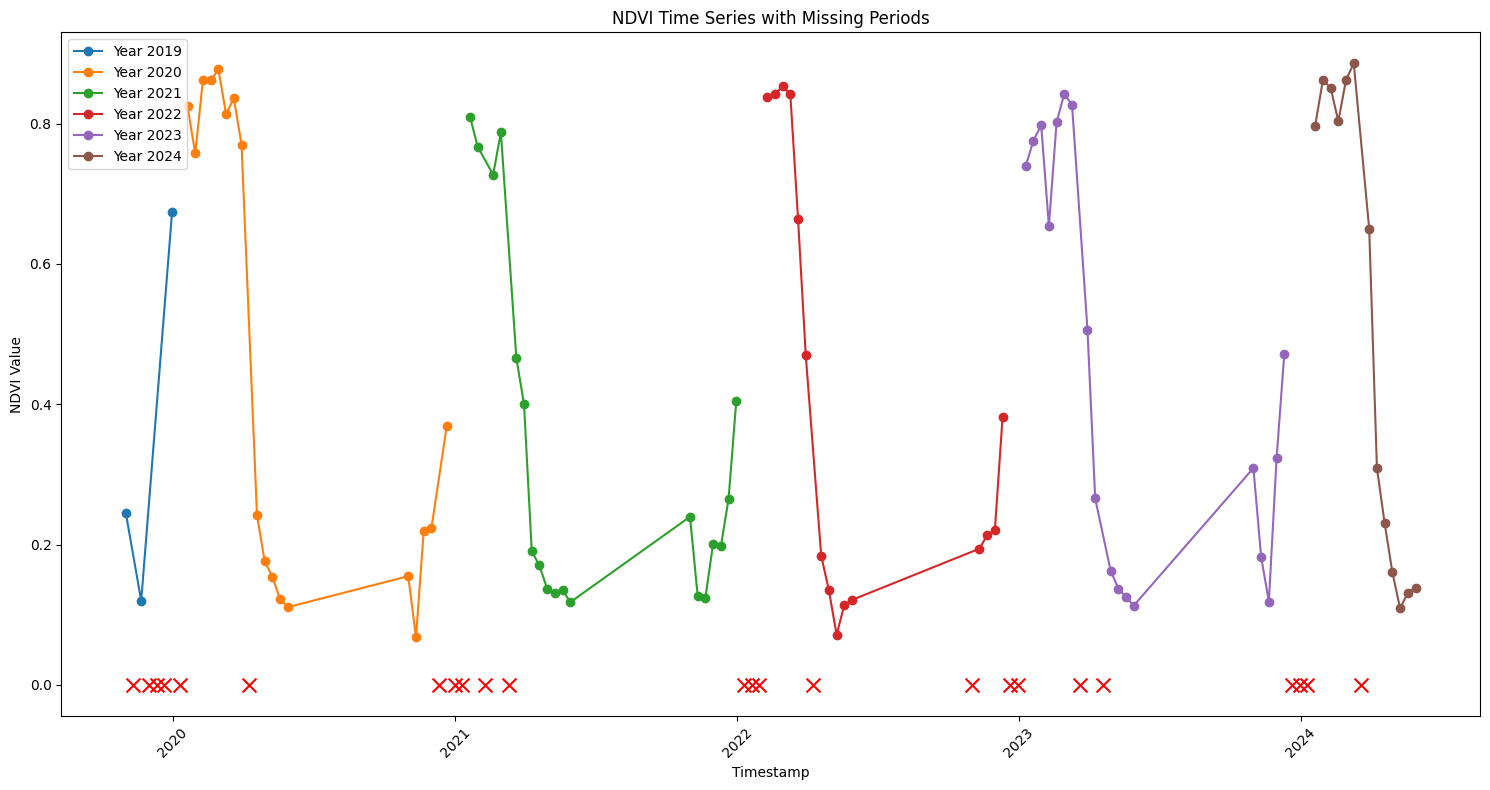

Missing NDVI Periods:
     timestamp  year  month
1   2019-11-11  2019     11
3   2019-12-01  2019     12
4   2019-12-11  2019     12
5   2019-12-21  2019     12
7   2020-01-10  2020      1
16  2020-04-09  2020      4
26  2020-12-11  2020     12
28  2020-12-31  2020     12
29  2021-01-10  2021      1
32  2021-02-09  2021      2
35  2021-03-11  2021      3
51  2022-01-10  2022      1
52  2022-01-20  2022      1
53  2022-01-30  2022      1
60  2022-04-10  2022      4
66  2022-11-01  2022     11
71  2022-12-21  2022     12
72  2022-12-31  2022     12
80  2023-03-21  2023      3
83  2023-04-20  2023      4
93  2023-12-21  2023     12
94  2023-12-31  2023     12
95  2024-01-10  2024      1
102 2024-03-20  2024      3


In [ ]:

 # Generate NDVI dataset
ndvi_df = create_ndvi_dataset(2019, 2023)

    # Plot and display results
result_df = plot_ndvi_dataset(ndvi_df)

    # Print summary of missing data
missing_summary = result_df[result_df['NDVIi'].isna()]
print("Missing NDVI Periods:")
print(missing_summary[['timestamp', 'year', 'month']])



In [ ]:
result_df

,timestamp,NDVIi,year,month
0,2019-11-01,0.245383,2019,11
1,2019-11-11,NaN,2019,11
2,2019-11-21,0.119827,2019,11
3,2019-12-01,NaN,2019,12
4,2019-12-11,NaN,2019,12
...,...,...,...,...
105,2024-04-19,0.230392,2024,4
106,2024-04-29,0.160804,2024,4
107,2024-05-09,0.109115,2024,5
108,2024-05-19,0.131149,2024,5


In [ ]:
print(result_df['NDVIi'].isna().sum())

24


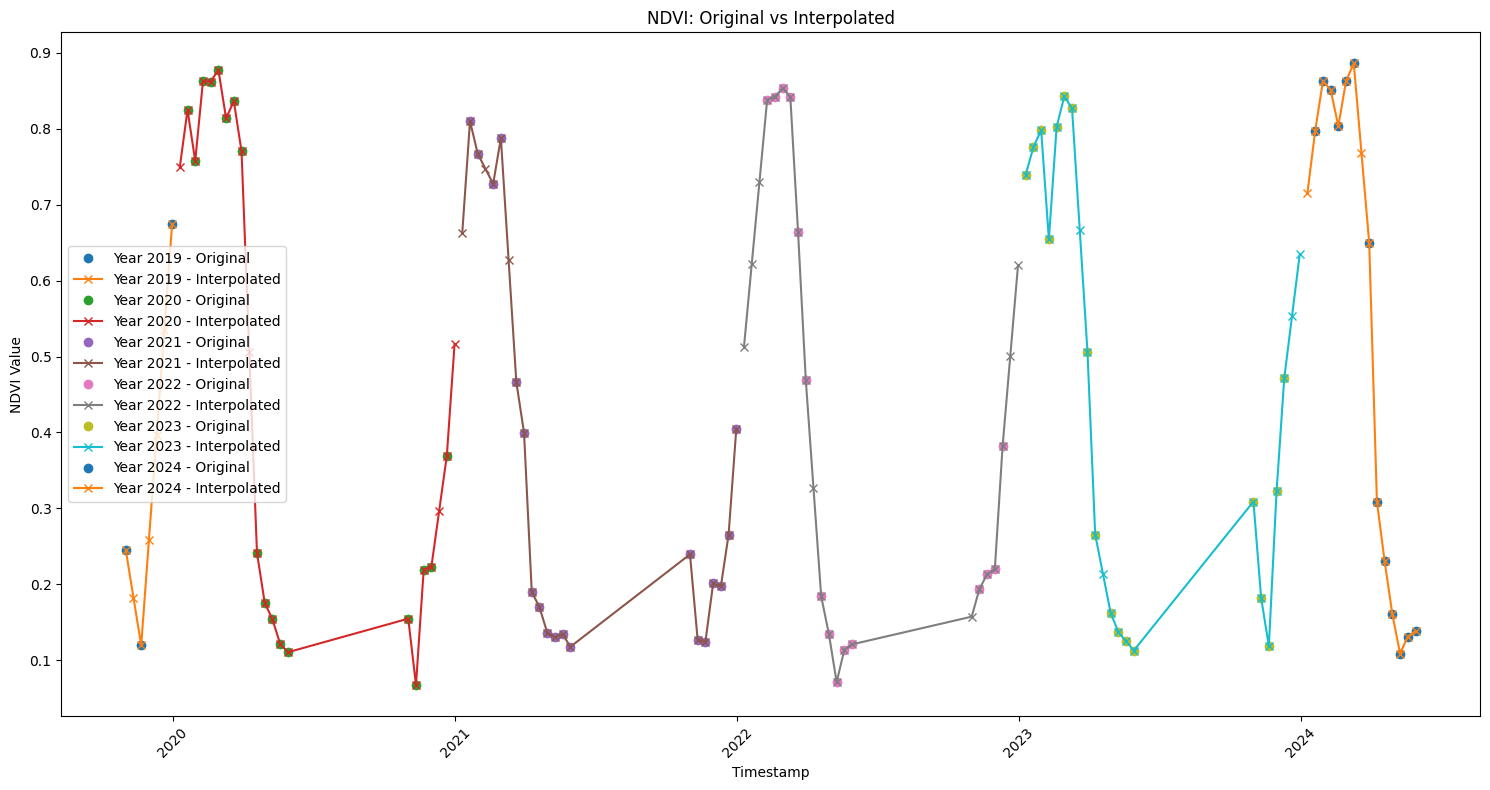

Missing values after interpolation: 0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def interpolate_ndvi(df):

    df_interpolated = df.copy()

    # Linear Interpolation with forward and backward fill
    df_interpolated['NDVIi_interpolated'] = df_interpolated['NDVIi'].interpolate(
        method='linear',
        limit_direction='both'  # Allow interpolation in both directions
    )

    # Fill any remaining NaNs with seasonal median
    df_interpolated['month_period'] = df_interpolated['timestamp'].dt.month.astype(str) + '_' + \
                                       (df_interpolated['timestamp'].dt.day // 10).astype(str)

    for month_period in df_interpolated['month_period'].unique():
        period_mask = df_interpolated['month_period'] == month_period
        median_value = df_interpolated[period_mask]['NDVIi_interpolated'].median()

        fill_mask = period_mask & df_interpolated['NDVIi_interpolated'].isna()
        df_interpolated.loc[fill_mask, 'NDVIi_interpolated'] = median_value

    # Visualization
    plt.figure(figsize=(15, 8))

    # Original and Interpolated Data
    years = df_interpolated['year'].unique()
    for year in years:
        year_data = df_interpolated[df_interpolated['year'] == year]

        plt.plot(year_data['timestamp'], year_data['NDVIi'],
                 marker='o', linestyle='', label=f'Year {year} - Original')
        plt.plot(year_data['timestamp'], year_data['NDVIi_interpolated'],
                 marker='x', linestyle='-', label=f'Year {year} - Interpolated')

    plt.title('NDVI: Original vs Interpolated')
    plt.xlabel('Timestamp')
    plt.ylabel('NDVI Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df_interpolated

result = interpolate_ndvi(result_df)
print("Missing values after interpolation:", result['NDVIi_interpolated'].isna().sum())

In [ ]:
print(result['NDVIi_interpolated'].isna())

0      False
1      False
2      False
3      False
4      False
       ...  
105    False
106    False
107    False
108    False
109    False
Name: NDVIi_interpolated, Length: 110, dtype: bool


In [ ]:
print(result)

     timestamp     NDVIi  year  month  NDVIi_interpolated month_period
0   2019-11-01  0.245383  2019     11            0.245383         11_0
1   2019-11-11       NaN  2019     11            0.182605         11_1
2   2019-11-21  0.119827  2019     11            0.119827         11_2
3   2019-12-01       NaN  2019     12            0.258313         12_0
4   2019-12-11       NaN  2019     12            0.396800         12_1
..         ...       ...   ...    ...                 ...          ...
105 2024-04-19  0.230392  2024      4            0.230392          4_1
106 2024-04-29  0.160804  2024      4            0.160804          4_2
107 2024-05-09  0.109115  2024      5            0.109115          5_0
108 2024-05-19  0.131149  2024      5            0.131149          5_1
109 2024-05-29  0.138777  2024      5            0.138777          5_2

[110 rows x 6 columns]


In [ ]:
result = result.drop(columns= ['month_period'])
result = result.drop(columns= ['NDVIi'])
print(result)

     timestamp  year  month  NDVIi_interpolated
0   2019-11-01  2019     11            0.245383
1   2019-11-11  2019     11            0.182605
2   2019-11-21  2019     11            0.119827
3   2019-12-01  2019     12            0.258313
4   2019-12-11  2019     12            0.396800
..         ...   ...    ...                 ...
105 2024-04-19  2024      4            0.230392
106 2024-04-29  2024      4            0.160804
107 2024-05-09  2024      5            0.109115
108 2024-05-19  2024      5            0.131149
109 2024-05-29  2024      5            0.138777

[110 rows x 4 columns]


In [ ]:
def analyze_crop_cycles(df):
    """Analyze crop cycles from 10-day interval NDVI data"""
    cycles = []

    for year in df['year'].unique():
        season_start = f"{year}-11-01"
        season_end = f"{year+1}-05-31"

        season_data = df[
            (df['timestamp'] >= season_start) &
            (df['timestamp'] <= season_end)
        ].copy()

        if not season_data.empty:
            # Calculate NDVI changes between consecutive readings
            season_data['ndvi_change'] = season_data['NDVIi_interpolated'].diff()

            # Find sustained growth initiation
            # Looking for 3 consecutive positive changes
            growth_start_idx = None
            for i in range(len(season_data) - 2):
                if (season_data['ndvi_change'].iloc[i:i+3] > 0.02).all():  # Threshold for meaningful change
                    growth_start_idx = i
                    break

            # Find peak NDVI
            peak_idx = season_data['NDVIi_interpolated'].idxmax()
            peak_row = season_data.loc[peak_idx]

            # Get sowing period
            sowing_period = season_data[
                season_data['timestamp'].dt.month == 11
            ].iloc[0]

            # Get growth initiation data if found
            growth_initiation = None
            growth_ndvi = None
            if growth_start_idx is not None:
                growth_initiation = season_data.iloc[growth_start_idx]['timestamp']
                growth_ndvi = season_data.iloc[growth_start_idx]['NDVIi_interpolated']

            # Get harvest period
            post_peak = season_data[season_data['timestamp'] > peak_row['timestamp']]

            cycles.append({
                'growing_season': f"{year}-{year+1}",
                'sowing_date': sowing_period['timestamp'],
                'sowing_ndvi': sowing_period['NDVIi_interpolated'],
                'growth_initiation_date': growth_initiation,
                'growth_initiation_ndvi': growth_ndvi,
                'peak_date': peak_row['timestamp'],
                'peak_ndvi': peak_row['NDVIi_interpolated'],
                'season_length_days': (post_peak.iloc[-1]['timestamp'] - sowing_period['timestamp']).days,
                'sowing_to_growth_days': (growth_initiation - sowing_period['timestamp']).days if growth_initiation else None,
                'growth_to_peak_days': (peak_row['timestamp'] - growth_initiation).days if growth_initiation else None
            })

    return pd.DataFrame(cycles)

def calculate_ndvi_thresholds(cycles_df):
    """Calculate NDVI thresholds for different growth stages"""
    thresholds = {
        'minimal_growth': cycles_df['sowing_ndvi'].mean(),
        'growth_initiation': cycles_df['growth_initiation_ndvi'].mean(),
        'active_growth': (cycles_df['growth_initiation_ndvi'].mean() + cycles_df['peak_ndvi'].mean()) / 2,
        'peak_growth': cycles_df['peak_ndvi'].mean(),
        'timing': {
            'avg_growth_initiation_month': cycles_df['growth_initiation_date'].dt.month.mode().iloc[0],
            'avg_days_to_growth': cycles_df['sowing_to_growth_days'].mean(),
            'avg_days_to_peak': cycles_df['growth_to_peak_days'].mean()
        }
    }
    return thresholds

# Example usage:
cycles = analyze_crop_cycles(result)
thresholds = calculate_ndvi_thresholds(cycles)

print("\nCrop Cycle Analysis with Growth Initiation:")
print(cycles[['growing_season', 'sowing_date', 'growth_initiation_date', 'peak_date',
              'growth_initiation_ndvi', 'peak_ndvi']])

print("\nNDVI Thresholds:")
for stage, value in thresholds.items():
    if stage != 'timing':
        print(f"{stage}: {value:.3f}")

print("\nTiming Patterns:")
for metric, value in thresholds['timing'].items():
    print(f"{metric}: {value:.1f}")


Crop Cycle Analysis with Growth Initiation:
  growing_season sowing_date growth_initiation_date  peak_date  \
0      2019-2020  2019-11-01             2019-12-01 2020-02-29   
1      2020-2021  2020-11-01             2020-12-11 2021-01-20   
2      2021-2022  2021-11-01             2021-12-21 2022-03-01   
3      2022-2023  2022-11-01             2022-12-11 2023-03-01   
4      2023-2024  2023-11-01             2023-12-01 2024-03-10   

   growth_initiation_ndvi  peak_ndvi  
0                0.258313   0.877207  
1                0.296606   0.809782  
2                0.265311   0.853184  
3                0.381595   0.842537  
4                0.322890   0.885730  

NDVI Thresholds:
minimal_growth: 0.221
growth_initiation: 0.305
active_growth: 0.579
peak_growth: 0.854

Timing Patterns:
avg_growth_initiation_month: 12.0
avg_days_to_growth: 38.0
avg_days_to_peak: 76.0


In [36]:
print("NDVI Data Statistics:")
print(result['NDVIi_interpolated'].describe())
print("\nStandard Deviation:", result['NDVIi_interpolated'].std())

NDVI Data Statistics:
count    110.000000
mean       0.449693
std        0.282906
min        0.067801
25%        0.177537
50%        0.398245
75%        0.748633
max        0.885730
Name: NDVIi_interpolated, dtype: float64

Standard Deviation: 0.2829062521452602


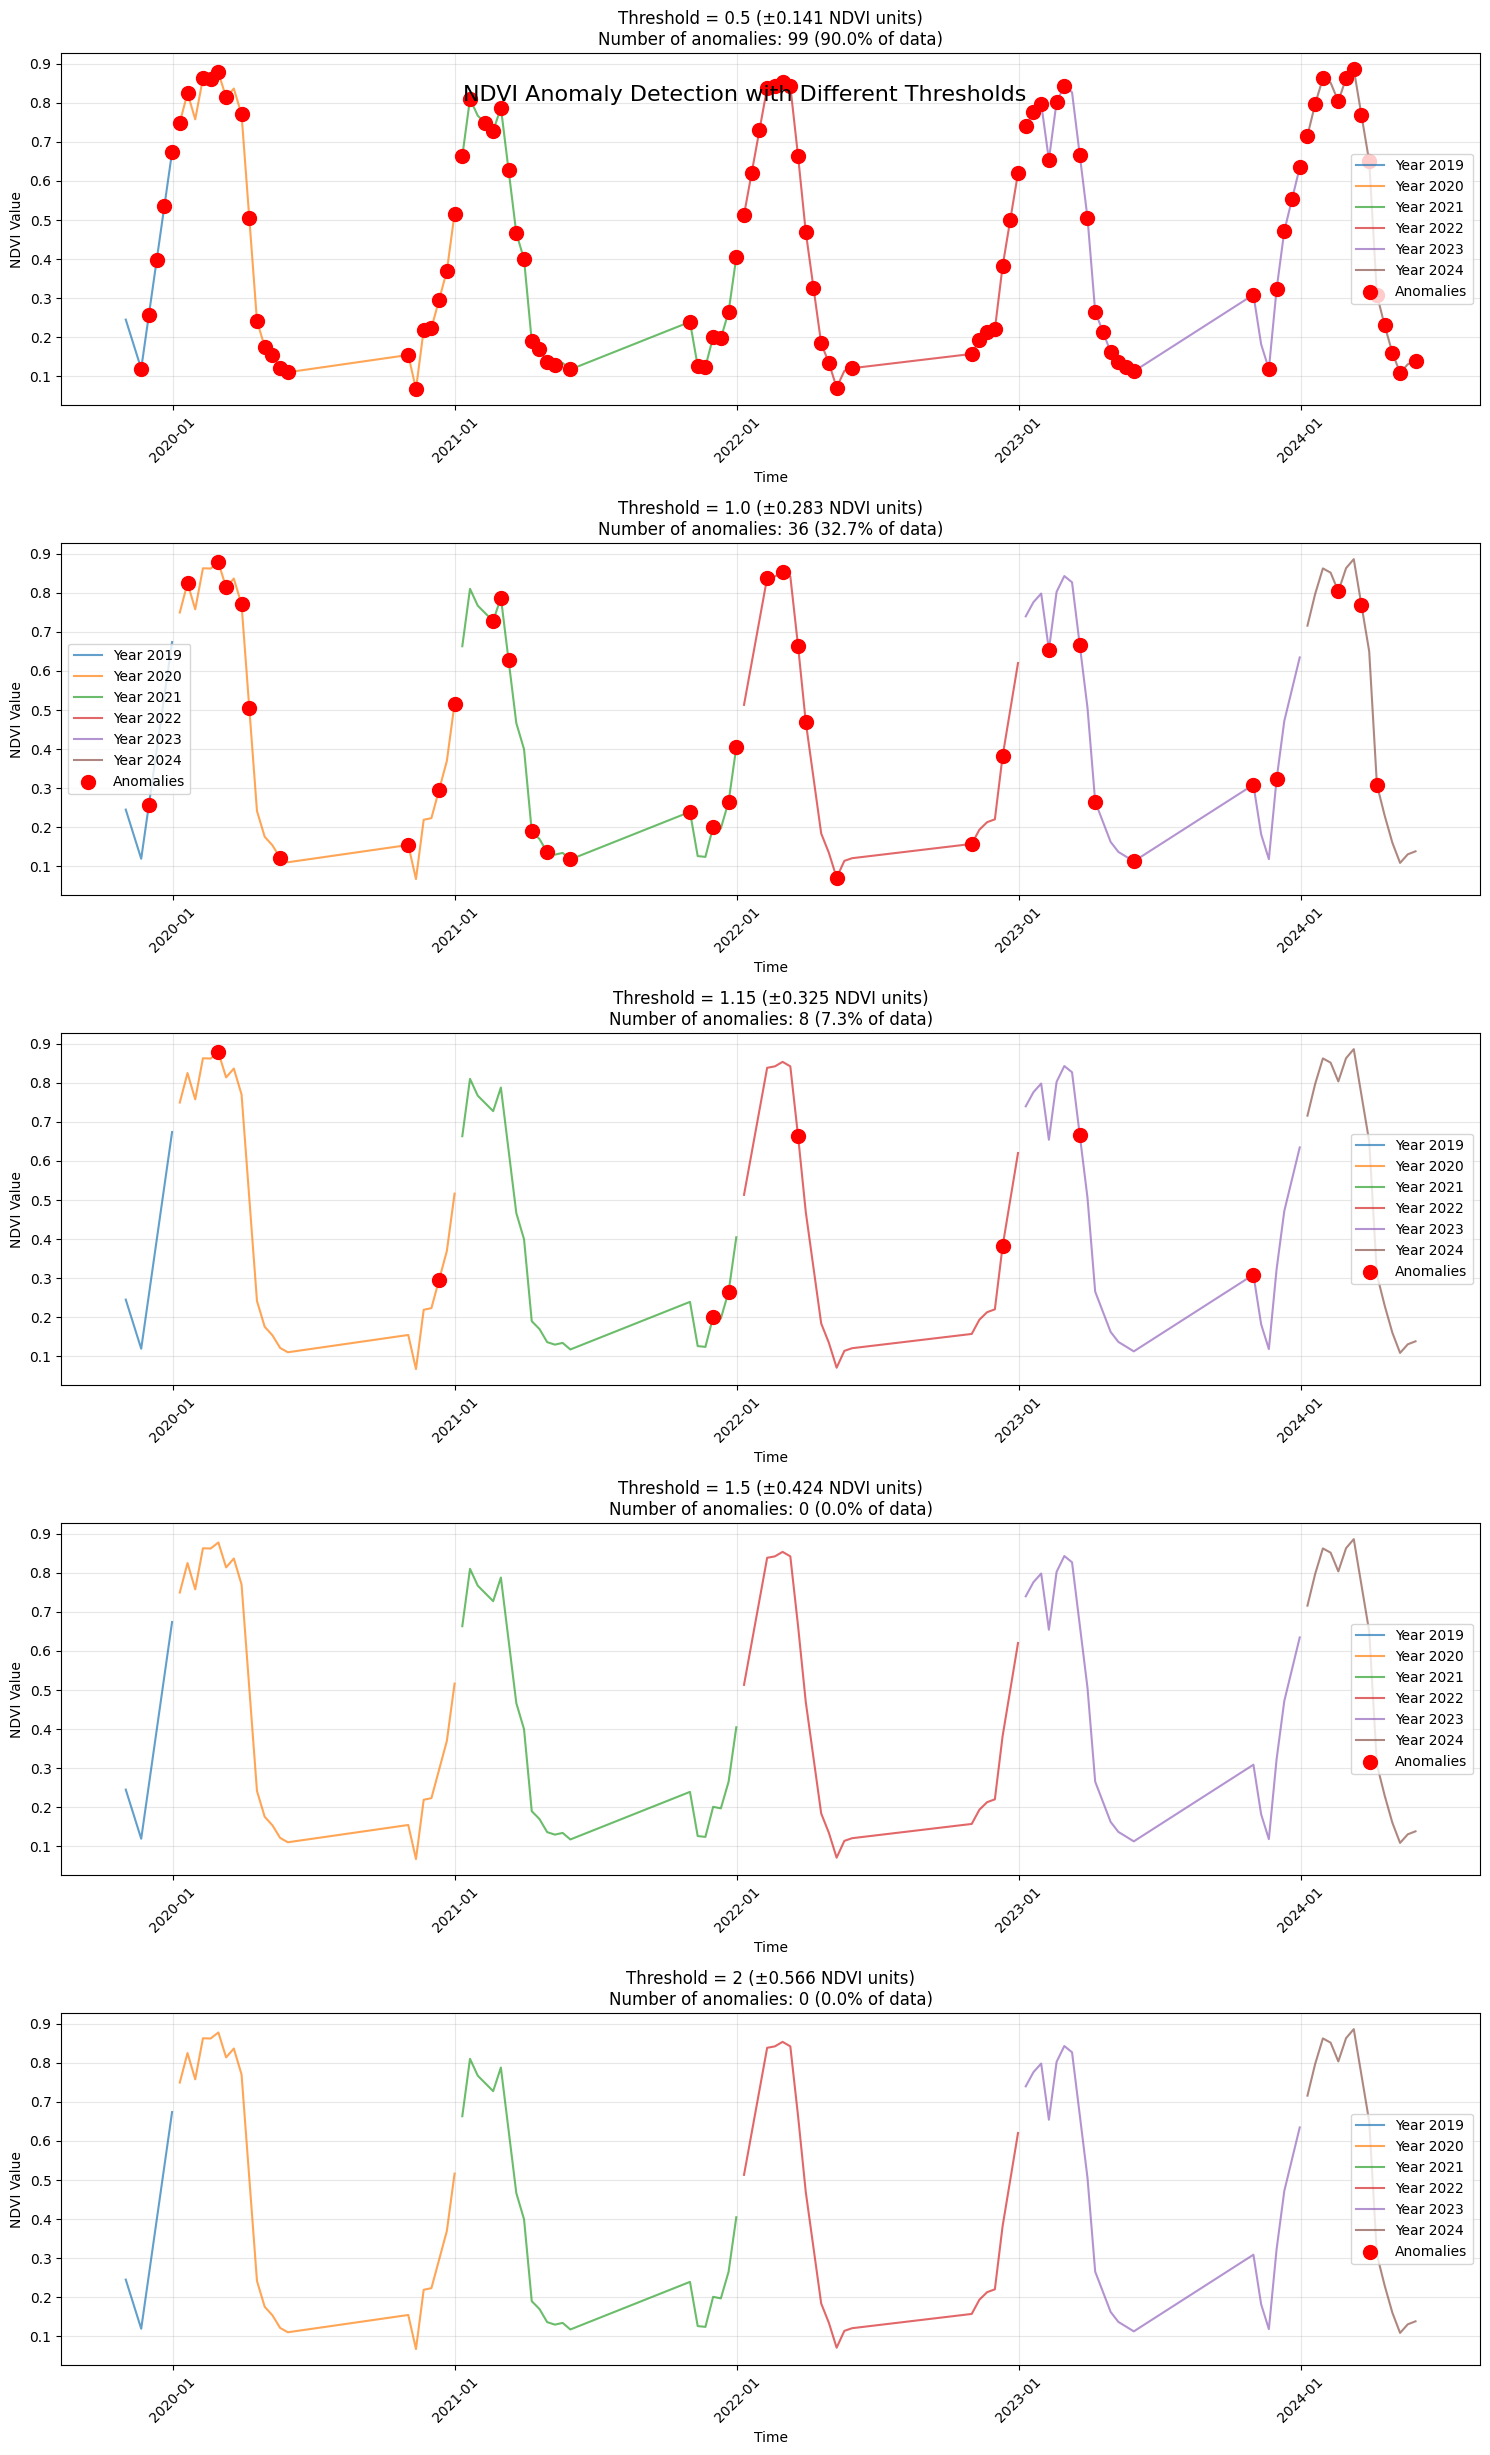


Detailed Threshold Analysis:
---------------------------

Threshold: 0.5
Allowed deviation: ±0.141 NDVI units
Number of anomalies: 99.0
Percentage of data flagged: 90.0%
Interpretation: Too sensitive

Threshold: 1.0
Allowed deviation: ±0.283 NDVI units
Number of anomalies: 36.0
Percentage of data flagged: 32.7%
Interpretation: Too sensitive

Threshold: 1.15
Allowed deviation: ±0.325 NDVI units
Number of anomalies: 8.0
Percentage of data flagged: 7.3%
Interpretation: Good sensitivity

Threshold: 1.5
Allowed deviation: ±0.424 NDVI units
Number of anomalies: 0.0
Percentage of data flagged: 0.0%
Interpretation: May miss anomalies

Threshold: 2.0
Allowed deviation: ±0.566 NDVI units
Number of anomalies: 0.0
Percentage of data flagged: 0.0%
Interpretation: May miss anomalies

NDVI Data Distribution:
----------------------
count    110.000000
mean       0.449693
std        0.282906
min        0.067801
25%        0.177537
50%        0.398245
75%        0.748633
max        0.885730
Name: NDVIi

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def analyze_threshold_impacts(df, thresholds=[0.5, 1.0, 1.15, 1.5, 2]):
    std_dev = df['NDVIi_interpolated'].std()
    window_size = 3

    # Create figure
    fig, axs = plt.subplots(len(thresholds), 1, figsize=(15, 5*len(thresholds)))
    fig.suptitle('NDVI Anomaly Detection with Different Thresholds', fontsize=16, y=0.95)

    results = []

    for idx, threshold in enumerate(thresholds):
        # Calculate rolling statistics
        rolling_mean = df['NDVIi_interpolated'].rolling(window=window_size).mean()
        rolling_std = df['NDVIi_interpolated'].rolling(window=window_size).std()

        # Define bounds
        upper_bound = rolling_mean + (threshold * rolling_std)
        lower_bound = rolling_mean - (threshold * rolling_std)

        # Detect anomalies
        anomalies = df[
            (df['NDVIi_interpolated'] > upper_bound) |
            (df['NDVIi_interpolated'] < lower_bound)
        ]

        # Calculate actual deviation range
        actual_deviation = threshold * std_dev

        # Store results
        results.append({
            'threshold': threshold,
            'num_anomalies': len(anomalies),
            'percentage': (len(anomalies) / len(df)) * 100,
            'deviation_range': actual_deviation
        })

        # Plot
        ax = axs[idx]

        # Plot original NDVI
        for year in df['year'].unique():
            year_data = df[df['year'] == year]
            ax.plot(year_data['timestamp'], year_data['NDVIi_interpolated'],
                   label=f'Year {year}', alpha=0.7)

        # Plot anomalies
        ax.scatter(anomalies['timestamp'], anomalies['NDVIi_interpolated'],
                  color='red', s=100, label='Anomalies', zorder=5)

        ax.set_title(f'Threshold = {threshold} (±{actual_deviation:.3f} NDVI units)\n'
                    f'Number of anomalies: {len(anomalies)} ({(len(anomalies)/len(df)*100):.1f}% of data)')
        ax.set_xlabel('Time')
        ax.set_ylabel('NDVI Value')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Format dates
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    results_df = pd.DataFrame(results)
    print("\nDetailed Threshold Analysis:")
    print("---------------------------")
    for _, row in results_df.iterrows():
        print(f"\nThreshold: {row['threshold']}")
        print(f"Allowed deviation: ±{row['deviation_range']:.3f} NDVI units")
        print(f"Number of anomalies: {row['num_anomalies']}")
        print(f"Percentage of data flagged: {row['percentage']:.1f}%")
        print(f"Interpretation: {'Too sensitive' if row['percentage'] > 20 else 'Good sensitivity' if 5 <= row['percentage'] <= 20 else 'May miss anomalies'}")

# Run the analysis
analyze_threshold_impacts(result)

# Print basic NDVI statistics for reference
print("\nNDVI Data Distribution:")
print("----------------------")
stats = result['NDVIi_interpolated'].describe()
print(stats)
print(f"\nStandard Deviation: {result['NDVIi_interpolated'].std():.3f}")

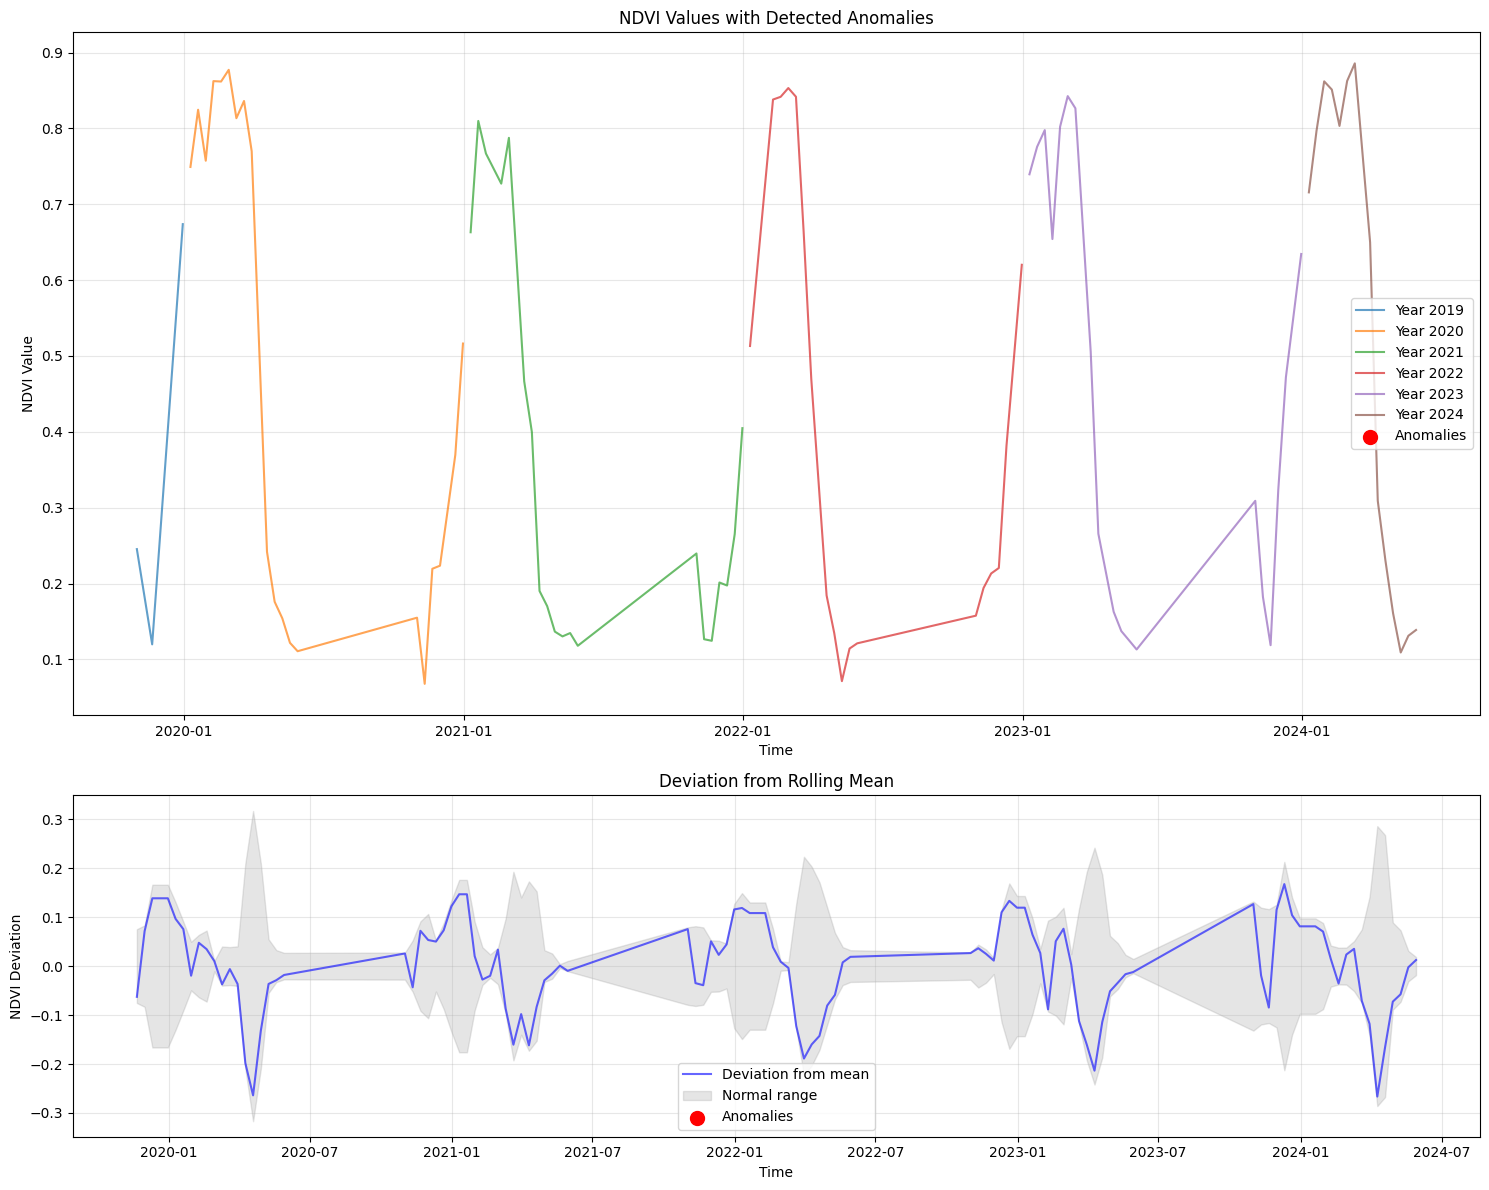


Anomaly Statistics:
Total number of anomalies detected: 0


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def detect_and_plot_anomalies(df, window_size=3, std_threshold = 1.2):
    # Calculate rolling statistics
    rolling_mean = df['NDVIi_interpolated'].rolling(window=window_size).mean()
    rolling_std = df['NDVIi_interpolated'].rolling(window=window_size).std()

    # Define upper and lower bounds
    upper_bound = rolling_mean + (std_threshold * rolling_std)
    lower_bound = rolling_mean - (std_threshold * rolling_std)

    # Detect anomalies
    anomalies = df[
        (df['NDVIi_interpolated'] > upper_bound) |
        (df['NDVIi_interpolated'] < lower_bound)
    ]

    # Create the visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])

    # Plot 1: Original NDVI with anomalies
    for year in df['year'].unique():
        year_data = df[df['year'] == year]
        ax1.plot(year_data['timestamp'], year_data['NDVIi_interpolated'],
                 label=f'Year {year}', alpha=0.7)

    # Highlight anomalies
    ax1.scatter(anomalies['timestamp'], anomalies['NDVIi_interpolated'],
                color='red', s=100, label='Anomalies', zorder=5)

    ax1.set_title('NDVI Values with Detected Anomalies')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('NDVI Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Deviation from rolling mean
    deviation = df['NDVIi_interpolated'] - rolling_mean
    ax2.plot(df['timestamp'], deviation, label='Deviation from mean', color='blue', alpha=0.6)
    ax2.fill_between(df['timestamp'],
                     -std_threshold * rolling_std,
                     std_threshold * rolling_std,
                     color='gray', alpha=0.2, label='Normal range')

    # Highlight anomalous deviations
    anomalous_deviations = deviation[
        (df['NDVIi_interpolated'] > upper_bound) |
        (df['NDVIi_interpolated'] < lower_bound)
    ]
    ax2.scatter(anomalous_deviations.index,
                anomalous_deviations.values,
                color='red', s=100, label='Anomalies', zorder=5)

    ax2.set_title('Deviation from Rolling Mean')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('NDVI Deviation')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Format dates on x-axis
    date_formatter = DateFormatter("%Y-%m")
    ax1.xaxis.set_major_formatter(date_formatter)
    ax2.xaxis.set_major_formatter(date_formatter)

    plt.tight_layout()
    plt.show()

    # Print anomaly statistics
    print("\nAnomaly Statistics:")
    print(f"Total number of anomalies detected: {len(anomalies)}")
    if not anomalies.empty:
          print("\nAnomalous dates and values:")
    for idx, row in anomalies.iterrows():
        print(f"Date: {row['timestamp'].strftime('%Y-%m-%d')}, "
              f"NDVI: {row['NDVIi_interpolated']:.3f}")

    return anomalies

# Use the function
anomalies = detect_and_plot_anomalies(result)

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def prepare_data(df, seq_length=6):  # 6 time steps = 60 days of history
    # Separate training (2019-2023) and testing (2024) data
    train_data = df[df['year'] < 2023]['NDVIi_interpolated'].values
    test_data = df[df['year'] >= 2023]['NDVIi_interpolated'].values

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    # Create sequences
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    return X_train, y_train, X_test, y_test, scaler

def build_lstm_model(seq_length):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Calculate accuracy as 1 - normalized RMSE
    accuracy = 1 - (rmse / (np.max(y_true) - np.min(y_true)))

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': accuracy
    }

def plot_results(actual, predicted, title='NDVI Predictions'):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', marker='o')
    plt.plot(predicted, label='Predicted', marker='x')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('NDVI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
def train_and_evaluate(df):
    # Prepare data
    X_train, y_train, X_test, y_test, scaler = prepare_data(df)

    # Build and train model
    model = build_lstm_model(X_train.shape[1])
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse transform predictions
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_orig = scaler.inverse_transform(y_train)
    y_test_orig = scaler.inverse_transform(y_test)

    # Evaluate model
    train_metrics = evaluate_predictions(y_train_orig, train_pred)
    test_metrics = evaluate_predictions(y_test_orig, test_pred)

    # Plot results
    plot_results(y_test_orig, test_pred, 'NDVI Predictions for 2024 (Test Set)')

    return train_metrics, test_metrics, model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.3778 - val_loss: 0.0935
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3662 - val_loss: 0.0891
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3553 - val_loss: 0.0848
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3565 - val_loss: 0.0803
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3483 - val_loss: 0.0755
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2908 - val_loss: 0.0703
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.3407 - val_loss: 0.0650
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.3032 - val_loss: 0.0598
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2666 - val_loss: 0.0545
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2600 - val_loss: 0.0495
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2479 - val_loss: 0.0450
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2216 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


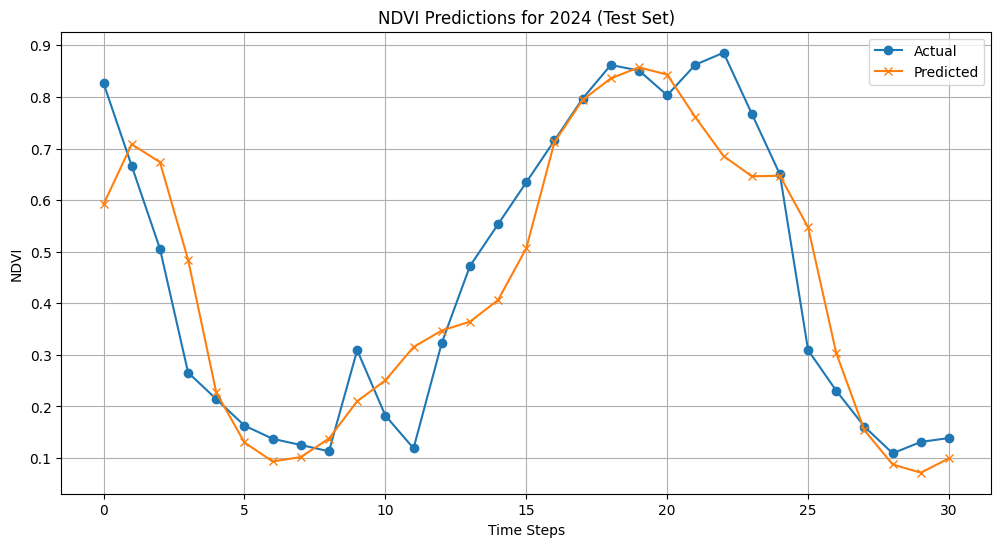


Training Metrics: {'RMSE': 0.07743962148157837, 'MAE': 0.05874845380475602, 'R2': 0.9235391960569272, 'Accuracy': 0.9043253762944493}

Test Metrics: {'RMSE': 0.11006383783035413, 'MAE': 0.08111485594423494, 'R2': 0.8531101097131507, 'Accuracy': 0.8582775041082851}


In [50]:
train_metrics, test_metrics, model = train_and_evaluate(result)
print("\nTraining Metrics:", train_metrics)
print("\nTest Metrics:", test_metrics)